In [46]:
import pandas as pd
import glob

# Be careful for changes at final github
working_pattern = 'DivvyData_part*.csv'

chunk_files = sorted(glob.glob(working_pattern))
data_chunks = []
for file in chunk_files:
    chunk = pd.read_csv(file, low_memory=False)
    data_chunks.append(chunk)
data = pd.concat(data_chunks, ignore_index=True)
del data_chunks

Final Cleaning for Linear Regression

In [47]:
df = data.drop(['ride_id', 'start_station_name','start_station_id','end_station_name', 'end_station_id', 'started_at_CT', 'day_of_week', 'end_hour', 'trip_category', 'end_lat', 'end_lng'], axis=1)

In [48]:
type_counts = df['rideable_type'].value_counts()
print(type_counts)
df = df[df['rideable_type'] != 'electric_scooter']
#Small percentage (1.1%) are electric scooters (Also not held at docking points like bikes) Removing

df = df[df['trip_duration_minutes']<=240]

rideable_type
classic_bike        2562761
electric_bike       1318381
electric_scooter      42897
Name: count, dtype: int64


In [ ]:
# Make Months categorical from data stamp and then make by season
from sklearn.model_selection import train_test_split


df['date'] = pd.to_datetime(df['date'])
df['month_num'] = df['date'].dt.month
df['month_name'] = df['date'].dt.strftime('%B') 
df = df.drop(['date', 'month_num' ], axis=1)
df['season'] = df['month_name'].map({
    'December': 'Winter', 'January': 'Winter', 'February': 'Winter',
    'March': 'Spring', 'April': 'Spring', 'May': 'Spring',
    'June': 'Summer', 'July': 'Summer', 'August': 'Summer',
    'September': 'Fall', 'October': 'Fall', 'November': 'Fall'
})

# Group hours
def categorize_hour(hour):
    if 6 <= hour <= 9:
        return '6-9AM: Early Morning'
    elif 10 <= hour <= 15:
        return '10AM-3PM: Midday'
    elif 16 <= hour <= 19:
        return '4-7PM: Early Evening'
    elif 20 <= hour <= 23:
        return '8-11PM: Evening'
    else:  # 0-5
        return '12-5AM: Overnight'

df['hour'] = df['hour'].apply(categorize_hour)


### Taking a stratified sample of the data to improve computational efficiency

## Data Visualisation for Regression

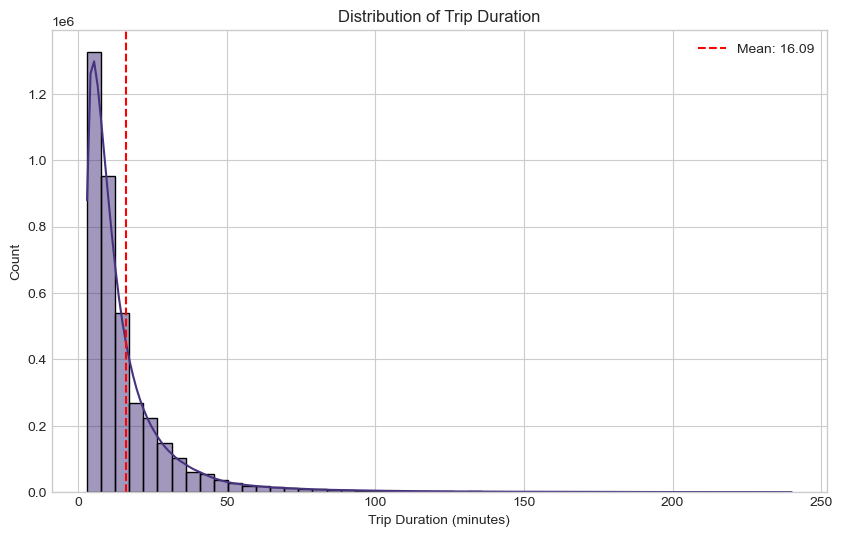

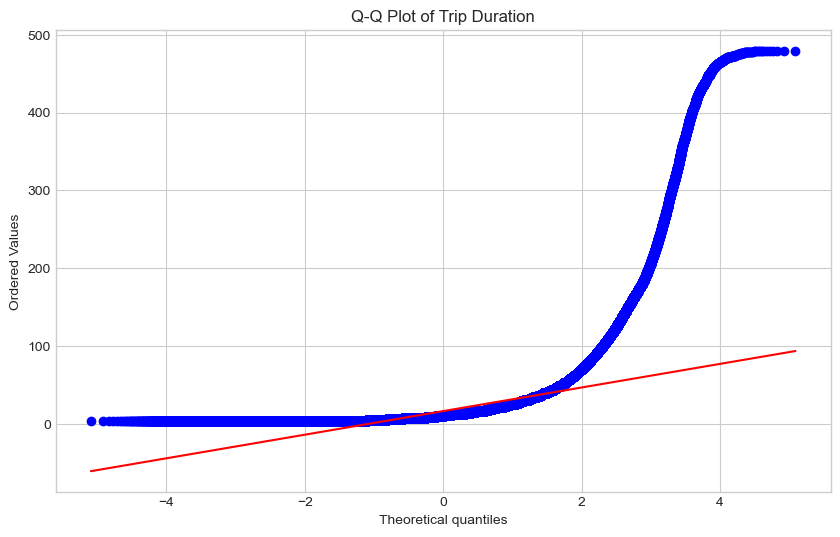

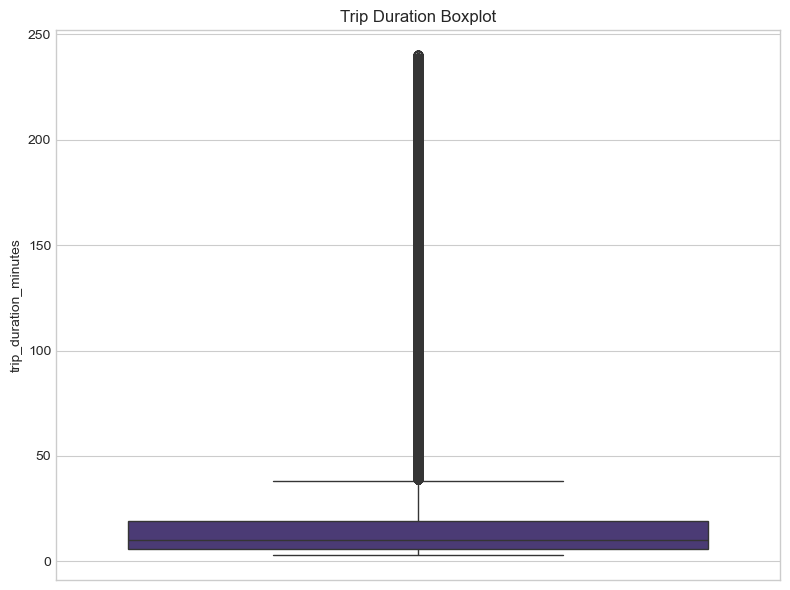

"# Variable Exploration\nfig, axes = plt.plot(figsize=(16, 12))\n\n# time group\nsns.boxplot('hour', y='trip_duration_minutes', data=df, ax=axes[0, 0])\naxes[0, 0].set_title('Trip Duration by Time Group')\naxes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45)\n\n#month\nsns.boxplot(x='month_name', y='trip_duration_minutes', data=df, ax=axes[0, 1])\naxes[0, 1].set_title('Trip Duration by Month')\naxes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45)\n# season\nsns.boxplot(x='season', y='trip_duration_minutes', data=df, ax=axes[2, 0])\naxes[1, 1].set_title('Season')\n\n# weekend status\nsns.boxplot(x='is_weekend', y='trip_duration_minutes', data=df, ax=axes[1, 0])\naxes[1, 0].set_title('Trip Duration by Weekend Status')\n\n# member type\nsns.boxplot(x='member_casual', y='trip_duration_minutes', data=df, ax=axes[1, 1])\naxes[1, 1].set_title('Trip Duration by Member Type')\n\nplt.tight_layout()\nplt.show()"

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Set up visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# Checking dist of trip duration
plt.figure(figsize=(10, 6))
sns.histplot(df['trip_duration_minutes'], bins=50, kde=True)
plt.title('Distribution of Trip Duration')
plt.xlabel('Trip Duration (minutes)')
plt.axvline(df['trip_duration_minutes'].mean(), color='red', linestyle='--', label=f'Mean: {df["trip_duration_minutes"].mean():.2f}')
plt.legend()
plt.show()

# Variable Exploration
plt.figure(figsize=(8, 6))
sns.boxplot(y='trip_duration_minutes', data=df)
plt.title('Trip Duration Boxplot')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

"""# Variable Exploration
fig, axes = plt.plot(figsize=(16, 12))

# time group
sns.boxplot('hour', y='trip_duration_minutes', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Trip Duration by Time Group')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45)

#month
sns.boxplot(x='month_name', y='trip_duration_minutes', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Trip Duration by Month')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45)
# season
sns.boxplot(x='season', y='trip_duration_minutes', data=df, ax=axes[2, 0])
axes[1, 1].set_title('Season')

# weekend status
sns.boxplot(x='is_weekend', y='trip_duration_minutes', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Trip Duration by Weekend Status')

# member type
sns.boxplot(x='member_casual', y='trip_duration_minutes', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Trip Duration by Member Type')

plt.tight_layout()
plt.show()"""

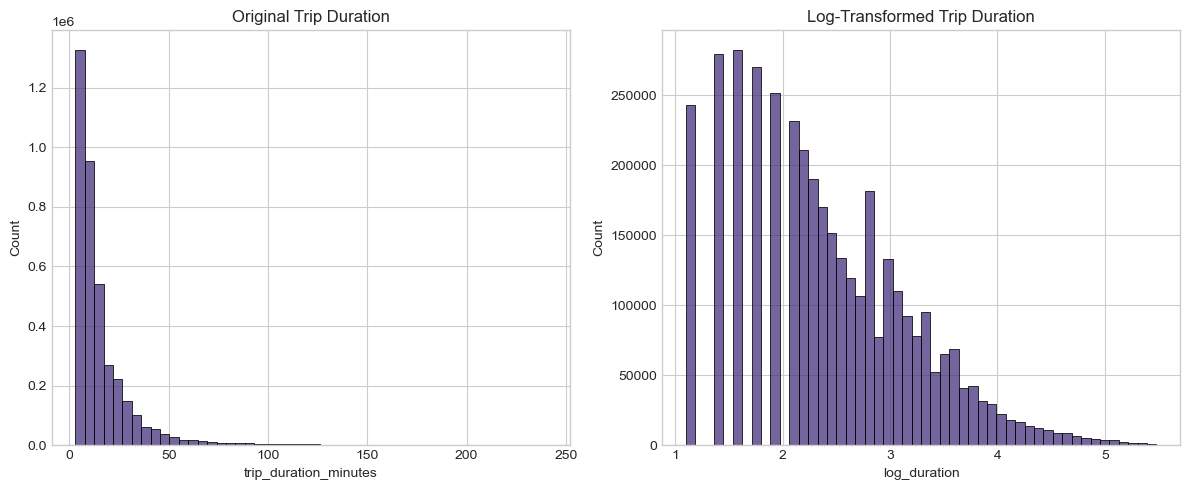

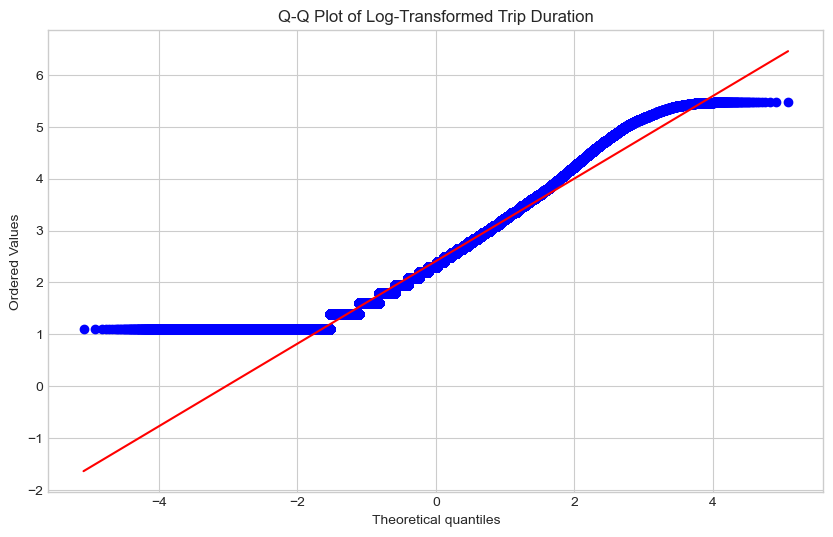

In [ ]:
# Applying and checking trip dispersity with log transform

# Apply log transformation to handle extreme skew
df['log_duration'] = np.log(df['trip_duration_minutes'])

# Verify the transformation improved distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['trip_duration_minutes'], bins=50)
plt.title('Original Trip Duration')
plt.subplot(1, 2, 2)
sns.histplot(df['log_duration'], bins=50)
plt.title('Log-Transformed Trip Duration')
plt.tight_layout()
plt.show()


## Linear Regression Model Building

In [52]:
import pandas as pd
import numpy as np
from sklearn.base import clone
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from tqdm.notebook import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import gc

In [53]:
df = df.drop(['month_name', 'ended_at_CT'], axis = 1)

In [ ]:
from scipy import sparse

categorical_features = ['hour', 'season', 'member_casual', 'rideable_type', 'is_weekend']
numerical_features = ['start_lat', 'start_lng']

X = df[categorical_features + numerical_features]
y = df['log_duration']

models = {
    # Linear Models
    'Linear': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    
    # Polynomial Models 
    'Poly2': Pipeline([
        ('poly', PolynomialFeatures(degree=2)),
        ('scaler', StandardScaler()),
        ('model', LinearRegression())  # Base
    ]),
    'Poly2+Ridge': Pipeline([
        ('poly', PolynomialFeatures(degree=2)),
        ('scaler', StandardScaler()),
        ('model', Ridge(alpha=1.0))  # Regularized
    ]),
    'Poly2+Lasso': Pipeline([
        ('poly', PolynomialFeatures(degree=2)),
        ('scaler', StandardScaler()),
        ('model', Lasso(alpha=0.1))  # Regularized 
    ])
}
# Create bins for stratification 
n_bins = min(10, len(y.unique()))  
y_binned = pd.qcut(y, q=n_bins, labels=False)

#Stratified train test split
X_sample, X_test, y_sample, y_test = train_test_split(
    X, y,
    test_size=0.5,
    random_state=42,
    stratify=y_binned
)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features), 
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

X_train_processed = preprocessor.fit_transform(X_sample)
X_test_processed = preprocessor.transform(X_test)


In [ ]:

def compute_model_complexity(model):
    
    if isinstance(model, Pipeline):
        steps = model.named_steps
        final_estimator = steps.get('model', model[-1])
        poly_degree = 1
        if 'poly' in steps:
            poly_degree = steps['poly'].degree
    else:
        final_estimator = model
        poly_degree = 1
    
    base_complexity = poly_degree**2  
    
    # Adjust for regularization 
    if isinstance(final_estimator, LinearRegression):
        reg_factor = 1.0
    elif isinstance(final_estimator, Ridge):
        reg_factor = 0.8
    elif isinstance(final_estimator, Lasso):
        reg_factor = 0.6
    else:
        reg_factor = 1.0
    
    return base_complexity * reg_factor

def evaluate_models(models, X_train, y_train, X_test, y_test, cv=3):
    results = []
    for name, model in tqdm(models.items(), desc="Evaluating"):
        try:
            current_model = clone(model)
            
            # Fit model
            current_model.fit(X_train, y_train)
            
            # Cross-validation
            cv_scores = cross_val_score(
                current_model, X_train, y_train,
                cv=cv, scoring='neg_mean_squared_error'
            )
            
            # Predictions
            test_pred = current_model.predict(X_test)
            
            # Simpler complexity calculation
            complexity = compute_model_complexity(current_model)
            
            results.append({
                'Model': name,
                'CV_MSE': -cv_scores.mean(),
                'CV_Std': cv_scores.std(),
                'Test_MSE': mean_squared_error(y_test, test_pred),
                'Complexity': complexity
            })
            
        except Exception as e:
            print(f"⚠️ {name} failed: {str(e)}")
    
    return pd.DataFrame(results)

# 3. Run evaluation
results_df = evaluate_models(
    models,
    X_train_processed,
    y_sample,
    X_test_processed,
    y_test,
    cv=3
)

# 4. Show results
if not results_df.empty:
    print(results_df.sort_values('CV_MSE'))
else:
    print("All models failed - check error messages above")

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

         Model    CV_MSE    CV_Std  Test_MSE  Complexity
4  Poly2+Ridge  0.551330  0.000910  0.550856         3.2
3        Poly2  0.551596  0.001145  0.550929         4.0
1        Ridge  0.575812  0.000784  0.575091         0.8
0       Linear  0.575816  0.000782  0.575094         1.0
5  Poly2+Lasso  0.601167  0.000785  0.600753         2.4
2        Lasso  0.648763  0.000591  0.648474         0.6


In [ ]:

def one_standard_error(results_df):
    min_error_model = results_df.loc[results_df['CV_MSE'].idxmin()]
    min_error = min_error_model['CV_MSE']
    min_std = min_error_model['CV_Std']
    
    threshold = min_error + min_std
    
    candidates = results_df[results_df['CV_MSE'] <= threshold]
    
    if not candidates.empty:
        best_model = candidates.loc[candidates['Complexity'].idxmin()]
        return best_model['Model']
    else:
        return min_error_model['Model']
    
print(one_standard_error(results_df))


Poly2+Ridge


## Refitting Best Model (Poly2+Ridge) and converting results for context

In [ ]:
# Fit the model on training data
poly_ridge_model = models['Poly2+Ridge']
poly_ridge_model.fit(X_train_processed, y_sample)

y_train_pred = poly_ridge_model.predict(X_train_processed)
y_test_pred = poly_ridge_model.predict(X_test_processed)

# Calculate metrics on log scale
train_log_rmse = np.sqrt(mean_squared_error(y_sample, y_train_pred))
test_log_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Training RMSE on log scale: {train_log_rmse:.6f}")
print(f"Test RMSE on log scale: {test_log_rmse:.6f}")

# Convert to original scale
y_train_original = np.exp(y_sample)
y_train_pred_original = np.exp(y_train_pred)
y_test_original = np.exp(y_test)
y_test_pred_original = np.exp(y_test_pred)

# Calculate metrics on original scale
train_original_rmse = np.sqrt(mean_squared_error(y_train_original, y_train_pred_original))
test_original_rmse = np.sqrt(mean_squared_error(y_test_original, y_test_pred_original))

print(f"Training RMSE on original scale: {train_original_rmse:.6f}")
print(f"Test RMSE on original scale: {test_original_rmse:.6f}")

Training RMSE on log scale: 0.742477
Test RMSE on log scale: 0.742197
Training RMSE on original scale: 18.125580
Test RMSE on original scale: 18.116800


In [58]:
def quantile_loss(y_true, y_pred, q=0.5):
    errors = y_true - y_pred
    return np.mean(np.maximum(q * errors, (q-1) * errors))

median_loss = quantile_loss(y_test_original, y_test_pred_original)
upper_loss = quantile_loss(y_test_original, y_test_pred_original, 0.75)
lower_loss = quantile_loss(y_test_original, y_test_pred_original, 0.25)
print(f"Median (50th percentile) loss: {median_loss:.6f}")
print(f"Upper Quartile (75th percentile) loss: {upper_loss:.6f}")
print(f"Lower Quartile (25th percentile) loss: {lower_loss:.6f}")

def percentile_error(y_true, y_pred, percentile=90):
    abs_errors = np.abs(y_true - y_pred)
    return np.percentile(abs_errors, percentile)

p75_error = percentile_error(y_test_original, y_test_pred_original, 75)
print(f"75% of predictions are within {p75_error:.2f} minutes of actual duration")

Median (50th percentile) loss: 4.642518
Upper Quartile (75th percentile) loss: 5.727083
Lower Quartile (25th percentile) loss: 3.557954
75% of predictions are within 9.34 minutes of actual duration


### Assessing Parameters of Poly2-Ridge model

Top 20 most important features in Poly2+Ridge model:
                                              Feature  Coefficient  \
35                                        start_lng^2     0.166149   
19                                start_lat start_lng     0.104769   
45                     start_lng member_casual_casual     0.069563   
152   member_casual_casual rideable_type_classic_bike     0.038758   
99     hour_6-9AM: Early Morning member_casual_casual     0.034767   
2                                           start_lng     0.027704   
100    hour_6-9AM: Early Morning member_casual_member    -0.025486   
31               start_lat rideable_type_classic_bike     0.025181   
36                    start_lng hour_10AM-3PM: Midday     0.024867   
43                            start_lng season_Summer     0.024138   
47               start_lng rideable_type_classic_bike     0.023494   
153  member_casual_casual rideable_type_electric_bike    -0.023086   
157   member_casual_member rideable_t

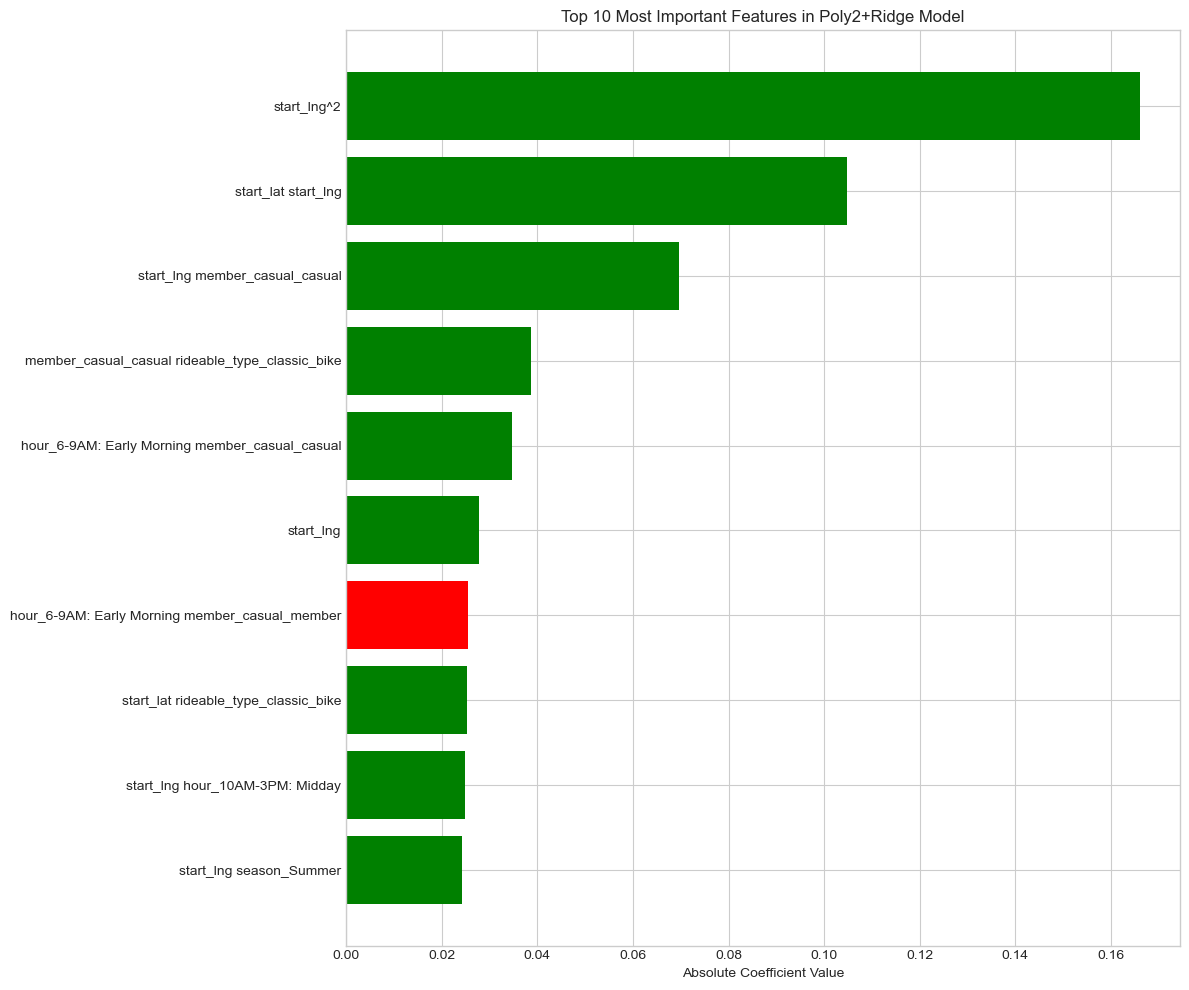


Top 10 most important original features:
                          Feature  Coefficient  Abs_Coefficient
35                    start_lng^2     0.166149         0.166149
2                       start_lng     0.027704         0.027704
1                       start_lat     0.021776         0.021776
13           member_casual_member    -0.018430         0.018430
12           member_casual_casual     0.018430         0.018430
150        member_casual_casual^2     0.018430         0.018430
156        member_casual_member^2    -0.018430         0.018430
14     rideable_type_classic_bike     0.011447         0.011447
15    rideable_type_electric_bike    -0.011447         0.011447
161  rideable_type_classic_bike^2     0.011447         0.011447

Top 10 most important interaction features:
                                              Feature  Coefficient  \
19                                start_lat start_lng     0.104769   
45                     start_lng member_casual_casual     0.069563   

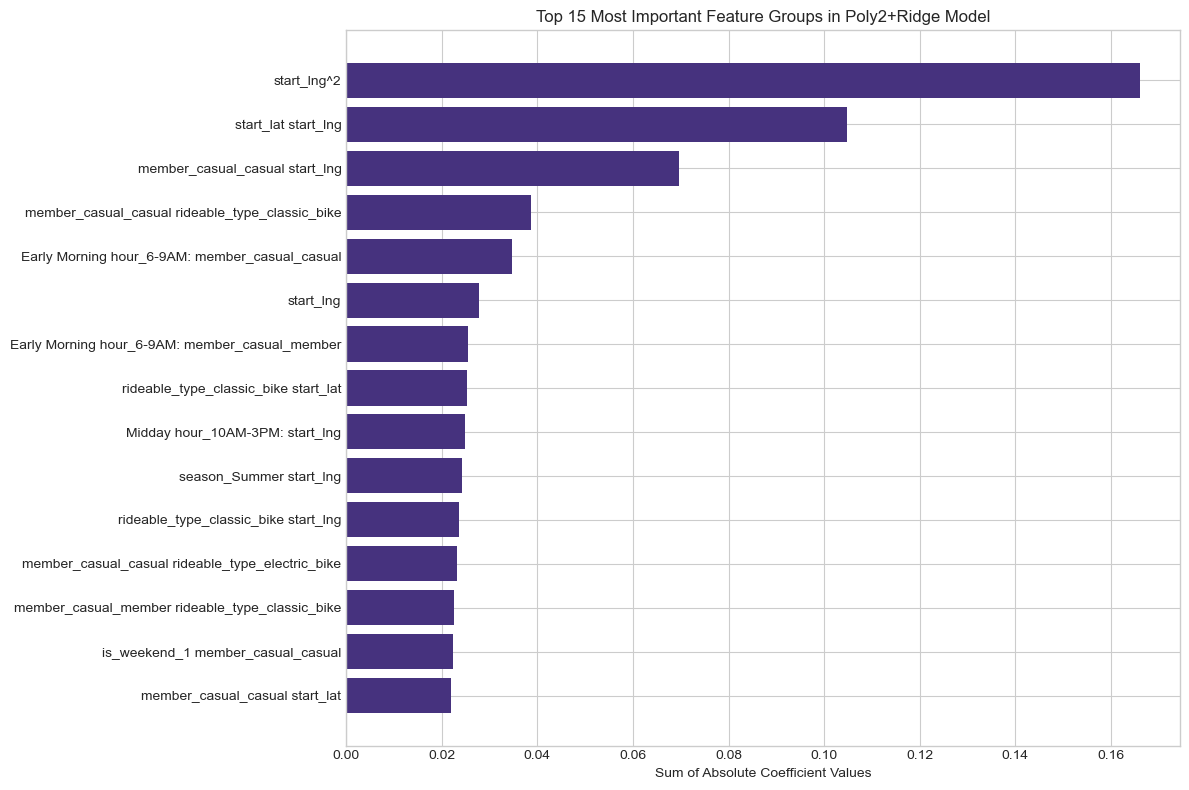


Number of near-zero coefficients: 20 out of 171
Percentage of near-zero coefficients: 11.70%


In [ ]:

poly_ridge_model = models['Poly2+Ridge']
poly_transformer = poly_ridge_model.named_steps['poly']
ridge_model = poly_ridge_model.named_steps['model']

# Get feature names
cat_encoder = preprocessor.named_transformers_['cat']
cat_features_encoded = cat_encoder.get_feature_names_out(categorical_features)
preprocessed_features = np.concatenate([numerical_features, cat_features_encoded])
poly_features = poly_transformer.get_feature_names_out(input_features=preprocessed_features)

# Get coefficients
coefficients = ridge_model.coef_
intercept = ridge_model.intercept_
coef_df = pd.DataFrame({
    'Feature': poly_features,
    'Coefficient': coefficients
})

# absolute value for sorting
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
sorted_coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

# Display most important feats
print("Top 20 most important features in Poly2+Ridge model:")
print(sorted_coef_df.head(20))



# Create visualization of feature importance
plt.figure(figsize=(12, 10))
top_n = 10 
colors = ['green' if x > 0 else 'red' for x in sorted_coef_df['Coefficient'][:top_n]]
plt.barh(sorted_coef_df['Feature'][:top_n], sorted_coef_df['Abs_Coefficient'][:top_n], color=colors)
plt.xlabel('Absolute Coefficient Value')
plt.title('Top 10 Most Important Features in Poly2+Ridge Model')
plt.gca().invert_yaxis()  # To have highest importance at the top
plt.tight_layout()
plt.show()

# Categorize features
original_features = sorted_coef_df[~sorted_coef_df['Feature'].str.contains(' ')]
print("\nTop 10 most important original features:")
print(original_features.head(10))

interaction_features = sorted_coef_df[sorted_coef_df['Feature'].str.contains(' ')]
print("\nTop 10 most important interaction features:")
print(interaction_features.head(10))

feature_groups = {}

# Process each feature
for feature in sorted_coef_df['Feature']:
    variables = feature.split(' ')
    variables.sort()
    group_key = ' '.join(variables)
    if group_key not in feature_groups:
        feature_groups[group_key] = []
    
    feature_groups[group_key].append(feature)

# Calculate importance by feature group
group_importance = {}
for group, features in feature_groups.items():
    group_coeffs = sorted_coef_df[sorted_coef_df['Feature'].isin(features)]['Coefficient'].values  
    group_importance[group] = np.sum(np.abs(group_coeffs))
group_df = pd.DataFrame({
    'Feature_Group': list(group_importance.keys()),
    'Importance': list(group_importance.values())
}).sort_values('Importance', ascending=False)


# Visualize top feature groups
plt.figure(figsize=(12, 8))
plt.barh(group_df['Feature_Group'][:15], group_df['Importance'][:15])
plt.xlabel('Sum of Absolute Coefficient Values')
plt.title('Top 15 Most Important Feature Groups in Poly2+Ridge Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Calculate number of near zero coefs
small_coef_threshold = 1e-4
small_coefs = np.sum(np.abs(coefficients) < small_coef_threshold)
print(f"\nNumber of near-zero coefficients: {small_coefs} out of {len(coefficients)}")